# Optimizing Nk Model using Evolutionary Algorithm
## by Saber Sheybani

## EA: DEAP Library

In [2]:
import random, time
from deap import creator, base, tools, algorithms
import itertools
import numpy as np
import numpy
from numpy import array as narr
import matplotlib.pyplot as plt
#import pickle

In [3]:
from nk import NK
from StrGraph import *

#import networkx
import jupyternotify # For notifications in the browser
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

## Set the Hyperparameters Here!

In [4]:
# Hyperparameters
N=50; K=1; # N, K from NK Model
genome_len = N; popsize = 50; NGEN = 100; 
cxpb = 0.5; mutpb = 1/popsize;
algo = algorithms.eaMuPlusLambda; mu = popsize; lambda_ = 2*popsize;
#algorithms.eaSimple
# Find selection method by searching register("select"

# Set up the Optimizer

In [5]:
# Objective function
def evalState(model, individual):
    return model.get_value(tuple(individual)),

# Set up the problem
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=genome_len)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the essential operators of the toolbox
toolbox.register("evaluate", evalState)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# Simple methods that are slow, but kinda work after many generations.
#toolbox.register("select", tools.selRoulette) # Fitness proportionate
toolbox.register("select", tools.selStochasticUniversalSampling) #Rank-based

# Best one
#toolbox.register("select", tools.selNSGA2, nd='standard')

# Fast, but get stuck in the first local optimum
#toolbox.register("select", tools.selBest)

# Other selection methods
#toolbox.register("select", tools.selAutomaticEpsilonLexicase)

pop = toolbox.population(n=popsize)
hof = tools.HallOfFame(10)

In [6]:
# My hybrid selection methods which keep an elitist group.
def selElitistAndRoulette(individuals, k):
    return tools.selBest(individuals, int(0.1*k)) + tools.selRoulette(individuals, k-int(0.1*k))
    #return tools.selBest(individuals, int(0.1*len(individuals))) + tools.selRoulette(individuals, len(individuals)-int(0.1*len(individuals)))
def selElitistAndSUS(individuals, k):
    return tools.selBest(individuals, int(0.1*k)) + tools.selStochasticUniversalSampling(individuals, k-int(0.1*k))
    #return tools.selBest(individuals, int(0.1*len(individuals))) + tools.selStochasticUniversalSampling(individuals, len(individuals)-int(0.1*len(individuals)))

#pop = tools.selBest(pop, int(0.1*len(pop))) + tools.selTournament(pop, len(pop)-int(0.1*len(pop)), tournsize=3)

In [7]:
# Specify Stats for recording the results
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("FitnessAvg", numpy.mean)
stats.register("FitnessStd", numpy.std)
#stats.register("min", numpy.min)
stats.register("FitnessMax", numpy.max)

# Average Fitness over Generations (for Multiple Ks)

In [22]:
# Run the algorithm 
start_time = time.time()
voi = 'FitnessMax'
voi2 = 'FitnessStd'
pbest_r = []
pstd_r = []
for K in range(1,N//10,1):
    nkmodel = NK(N, K)
    toolbox.register("evaluate", evalState, nkmodel)
    toolbox.register("select", selElitistAndSUS)
#     pop, logbook = algo(pop, toolbox, cxpb, mutpb, NGEN, stats=stats,
#                                    halloffame=hof, verbose=False)
    pop, logbook = algo(pop, toolbox, mu, lambda_, cxpb, mutpb, NGEN, stats=stats,
                        halloffame=hof, verbose=False)
    pbest_r += [logbook.select(voi)]
    pstd_r += [logbook.select(voi2)]
#     with open("logfile.pkl", "wb") as log_file:
#         pickle.dump(logbook, log_file)
elapsed_time = time.time() - start_time
print("Done! Elapsed time = ",elapsed_time)

Done! Elapsed time =  4.9393579959869385


# Plot Results

In [ ]:
# Plot Results
x = logbook.select('gen')
#pbest, pavg, pstd = logbook.select("max", "avg", "std")

fig, ax = plt.subplots(1,1, figsize=(12, 5))
for i in range(len(pbest_r)):
    ax.plot(x, pbest_r[i], label='K='+str(i+1))
    #ax.plot(x, pstd_r[i], label='K='+str(i))
#ax[0].plot(x, pavg, "--b")

ax.grid(True)
ax.set_title("Best Fitness over Generations (for Multiple Ks), N="+str(N))
ax.legend()
ax.set_xlabel('Generation')
ax.set_ylabel(voi2)

plt.show()

In [9]:
# nkmodel.values

In [10]:
# print(nkmodel.get_value([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0]))
# print(nkmodel.get_value([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [11]:
# pop

In [ ]:
G = StrGraph(pop)
G.layout(prog='twopi')
G.draw('testgraph.png')
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mpimg.imread('testgraph.png'))

# Best Fitness over Multiple Runs (for multiple Ks)

In [13]:
# Run the algorithm 
nRun = 10; Kmax = N//10
voi = 'FitnessMax'
start_time = time.time()
pbest_r = np.zeros((nRun, Kmax))
for K in range(0,Kmax+1,2):
    nkmodel = NK(N, K)
    toolbox.register("evaluate", evalState, nkmodel)
    for r in range(nRun):
#         pop, logbook = algo(pop, toolbox, cxpb, mutpb, NGEN, stats=stats,
#                                    halloffame=hof, verbose=False)
        pop, logbook = algo(pop, toolbox, mu, lambda_, cxpb, mutpb, NGEN, stats=stats,
                                   halloffame=hof, verbose=False)
        pbest_r[r, K-1] = logbook.select(voi)[0]
#     with open("logfile.pkl", "wb") as log_file:
#         pickle.dump(logbook, log_file)
elapsed_time = time.time() - start_time
print("Done! Elapsed time = ",elapsed_time)
%notify

Done! Elapsed time =  37.736443519592285


<IPython.core.display.Javascript object>

In [14]:
# pop

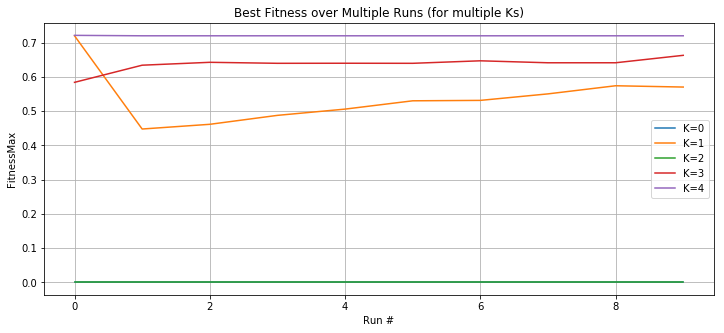

In [15]:
# Plot Results
x = np.arange(nRun)
fig, ax = plt.subplots(1,1, figsize=(12, 5))
for k in range(pbest_r.shape[1]):
    ax.plot(x, pbest_r[:,k], label='K='+str(k))

ax.grid(True)
ax.set_title("Best Fitness over Multiple Runs (for multiple Ks)")
ax.legend()
ax.set_xlabel('Run #')
ax.set_ylabel(voi)
plt.show()

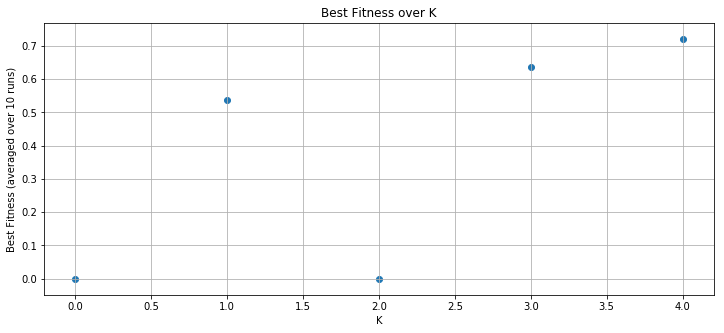

In [16]:
x = np.arange(0, Kmax)
fig, ax = plt.subplots(1,1, figsize=(12, 5))
ax.scatter(x, np.mean(pbest_r, axis=0))

ax.grid(True)
ax.set_title("Best Fitness over K")
#ax.legend()
ax.set_xlabel('K')
ax.set_ylabel('Best Fitness (averaged over 10 runs)')
plt.show()

# Final Plot: Compare the (averaged over 10 runs) convergence (best and variance) of selection strategies for:
- k=0
- k=1
- k=2
- k=5
- k=25
over generations

best fitness array: 5x3x10x100
avg fitness array, std fitness array

In [8]:
# Run the algorithm 
N=50;
nRun = 10; Ks = [0, 1, 2, 5, 25];
voi1 = 'FitnessMax'
voi2 = 'FitnessStd'
voi3 = 'FitnessAvg'
sel_methods = [tools.selBest, selElitistAndRoulette, selElitistAndSUS]
MaxVals1 = np.zeros((len(Ks),len(sel_methods), nRun, NGEN))
StdVals1 = np.zeros((len(Ks),len(sel_methods), nRun, NGEN))
AvgVals1 = np.zeros((len(Ks),len(sel_methods), nRun, NGEN))


start_time = time.time()

for i, K in enumerate(Ks):
    print('K = '+ str(K)+ ' started!'+'Elapsed time = '+str(time.time() - start_time))
    nkmodel = NK(N, K)
    toolbox.register("evaluate", evalState, nkmodel)
    for j, sel_method in enumerate(sel_methods):
        print('Method '+ str(j)+ ' started!')
        toolbox.register("select", sel_method)
        for r in range(nRun):
            pop = toolbox.population(n=popsize)
            pop, logbook = algo(pop, toolbox, mu, lambda_, cxpb, mutpb, NGEN, stats=stats,
                                halloffame=hof, verbose=False)
            MaxVals1[i, j, r, :] = logbook.select(voi1)[:NGEN]
            StdVals1[i, j, r, :] = logbook.select(voi2)[:NGEN]
            AvgVals1[i, j, r, :] = logbook.select(voi3)[:NGEN]

elapsed_time = time.time() - start_time
print("Done! Elapsed time = ",elapsed_time)
%notify



K = 0 started!Elapsed time = 0.00020933151245117188
Method 0 started!
Method 1 started!
Method 2 started!
K = 1 started!Elapsed time = 30.826651334762573
Method 0 started!
Method 1 started!
Method 2 started!
K = 2 started!Elapsed time = 62.51717257499695
Method 0 started!
Method 1 started!
Method 2 started!
K = 5 started!Elapsed time = 94.34539699554443
Method 0 started!
Method 1 started!
Method 2 started!
K = 25 started!Elapsed time = 127.87163066864014
Method 0 started!
Method 1 started!
Method 2 started!
Done! Elapsed time =  281.8942835330963


<IPython.core.display.Javascript object>

In [30]:
np.savez('outfiles', MaxVals1, StdVals1, AvgVals1)

In [9]:
ravgMax = np.mean(MaxVals1[:,:,:,:], axis=2)
ravgAvg = np.mean(AvgVals1[:,:,:,:], axis=2)
ravgStd = np.mean(StdVals1[:,:,:,:], axis=2)

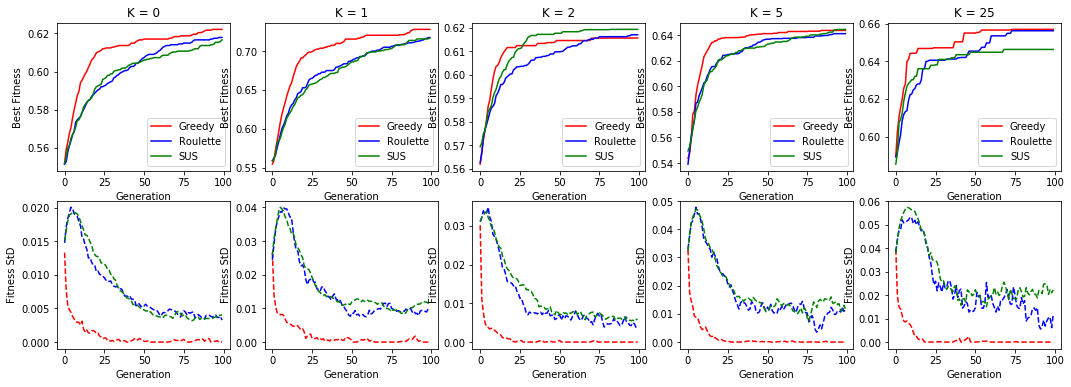

In [10]:
fig, ax = plt.subplots(2,5, figsize=(18,6))
gen = np.arange(ravgMax.shape[-1])
Ks = [0, 1, 2, 5, 25]
for i in range(ravgMax.shape[0]):
    ax[0,i].plot(gen, ravgMax[i, 0,:], '-r', label='Greedy')
    #ax[0, i].plot(gen, ravgStd[i, 0,:], '--r')
    #ax[i].plot(gen, ravgAvg[i, 0,:], '--r')
    
    ax[0,i].plot(gen, ravgMax[i, 1,:], 'b-', label='Roulette')
    #ax[i].plot(gen, ravgStd[i, 1,:], 'b--')
    #ax[i].plot(gen, ravgAvg[i, 1,:], 'b--')
    
    ax[0,i].plot(gen, ravgMax[i, 2,:], 'g-', label='SUS')
    #ax[i].plot(gen, ravgStd[i, 2,:], 'g--')
    #ax[i].plot(gen, ravgAvg[i, 2,:], 'g--')
    
    ax[0,i].set_xlabel('Generation')
    ax[0,i].set_ylabel('Best Fitness')
    ax[0,i].legend()
    ax[0,i].title.set_text('K = '+str(Ks[i]))
    
for i in range(ravgMax.shape[0]):
    #ax[0,i].plot(gen, ravgMax[i, 0,:], '-r', label='Greedy')
    ax[1,i].plot(gen, ravgStd[i, 0,:], '--r')
    #ax[i].plot(gen, ravgAvg[i, 0,:], '--r')
    
    #ax[1,i].plot(gen, ravgMax[i, 1,:], 'b-', label='Roulette')
    ax[1,i].plot(gen, ravgStd[i, 1,:], 'b--')
    #ax[i].plot(gen, ravgAvg[i, 1,:], 'b--')
    
    #ax[0,i].plot(gen, ravgMax[i, 2,:], 'g-', label='SUS')
    ax[1,i].plot(gen, ravgStd[i, 2,:], 'g--')
    #ax[i].plot(gen, ravgAvg[i, 2,:], 'g--')
    
    ax[1,i].set_xlabel('Generation')
    ax[1,i].set_ylabel('Fitness StD')
    #ax[1,i].legend()
    #ax[0,i].title.set_text('K = '+str(Ks[i]))

In [ ]:
plt.savefig('mainfig.svg',dpi=100)

In [ ]:
t_num = 0
fig, ax = plt.subplots(1,5, figsize=(18,4))
gen = np.arange(ravgMax.shape[-1])
Ks = [0, 1, 2, 5, 25]
for i in range(ravgMax.shape[0]):
    ax[i].plot(gen, MaxVals[i, 0,t_num, :], '-r', label='Greedy')
    #ax[i].plot(gen, StdVals[i, 0,t_num, :], '--r')
    #ax[i] = plt.plot(gen, ravgAvg[i, 0,:])
    
    ax[i].plot(gen, MaxVals[i, 1,t_num, :], 'b-', label='Roulette')
    #ax[i].plot(gen, StdVals[i, 1,:], 'b--')
    
    ax[i].plot(gen, MaxVals[i, 2,t_num, :], 'g-', label='SUS')
    #ax[i].plot(gen, StdVals[i, 2,t_num, :], 'g--')
    
    ax[i].set_xlabel('Generation')
    ax[i].set_ylabel('Fitness(solid), Std(dashed)')
    ax[i].legend()
    ax[i].title.set_text('K = '+str(Ks[i]))

In [ ]:
# Run the algorithm: Compare selBest with NSGA
N=50;
nRun = 5; Ks = [0, 1, 2, 5, 25];
voi1 = 'FitnessMax'
voi2 = 'FitnessStd'
voi3 = 'FitnessAvg'
sel_methods = [tools.selBest, tools.selNSGA2]
MaxVals1 = np.zeros((len(Ks),len(sel_methods), nRun, NGEN))
StdVals1 = np.zeros((len(Ks),len(sel_methods), nRun, NGEN))
AvgVals1 = np.zeros((len(Ks),len(sel_methods), nRun, NGEN))


start_time = time.time()

for i, K in enumerate(Ks):
    print('K = '+ str(K)+ ' started!'+'Elapsed time = '+str(time.time() - start_time))
    nkmodel = NK(N, K)
    toolbox.register("evaluate", evalState, nkmodel)
    for j, sel_method in enumerate(sel_methods):
        print('Method '+ str(j)+ ' started!')
        if sel_method == tools.selNSGA2:
            toolbox.register("select", tools.selNSGA2, nd='standard')
        else:
            toolbox.register("select", sel_method)
        for r in range(nRun):
            pop = toolbox.population(n=popsize)
            pop, logbook = algo(pop, toolbox, mu, lambda_, cxpb, mutpb, NGEN, stats=stats,
                                halloffame=hof, verbose=False)
            MaxVals1[i, j, r, :] = logbook.select(voi1)[:NGEN]
            StdVals1[i, j, r, :] = logbook.select(voi2)[:NGEN]
            AvgVals1[i, j, r, :] = logbook.select(voi3)[:NGEN]

elapsed_time = time.time() - start_time
print("Done! Elapsed time = ",elapsed_time)
%notify


In [27]:
ravgMax = np.mean(MaxVals1[:,:,:,:], axis=2)
ravgAvg = np.mean(AvgVals1[:,:,:,:], axis=2)
ravgStd = np.mean(StdVals1[:,:,:,:], axis=2)

In [ ]:
# Run the algorithm: No elitist group
N=50;
nRun = 10; Ks = [0, 1, 2, 5, 25];
voi1 = 'FitnessMax'
voi2 = 'FitnessStd'
voi3 = 'FitnessAvg'

sel_methods = [tools.selBest, tools.selRoulette, tools.selStochasticUniversalSampling]
MaxVals = np.zeros((len(Ks),len(sel_methods), nRun, NGEN))
StdVals = np.zeros((len(Ks),len(sel_methods), nRun, NGEN))
AvgVals = np.zeros((len(Ks),len(sel_methods), nRun, NGEN))


start_time = time.time()

for i, K in enumerate(Ks):
    print('K = '+ str(K)+ ' started!'+'Elapsed time = '+str(time.time() - start_time))
    nkmodel = NK(N, K)
    toolbox.register("evaluate", evalState, nkmodel)
    for j, sel_method in enumerate(sel_methods):
        print('Method '+ str(j)+ ' started!')
        toolbox.register("select", sel_method)
        for r in range(nRun):
            pop = toolbox.population(n=popsize)
            pop, logbook = algo(pop, toolbox, mu, lambda_, cxpb, mutpb, NGEN, stats=stats,
                                halloffame=hof, verbose=False)
            MaxVals[i, j, r, :] = logbook.select(voi1)[:NGEN]
            StdVals[i, j, r, :] = logbook.select(voi2)[:NGEN]
            AvgVals[i, j, r, :] = logbook.select(voi3)[:NGEN]

elapsed_time = time.time() - start_time
print("Done! Elapsed time = ",elapsed_time)
%notify
